# Introduzione

La piattaforma beehAIve è concepita con lo scopo di predire il **Colony Collapse Disorder (CCD)**, monitorando attentamente lo stato di salute delle arnie. Per raggiungere tale obiettivo, abbiamo la necessità di raccogliere dati rilevanti per il monitoraggio della salute delle arnie. Tra questi, vi è una caratteristica estremamente importante, ovvero **la presenza e l'assenza dell'ape regina**.


Attualmente, non esiste alcun modo per stabilire la presenza e/o l'assenza dell'ape regina all'interno di un'arnia in maniera automatizzata. Esistono, tuttavia, dei metodi per determinare la presenza o l'assenza della regina all'interno di un'arnia. Tra questi, vi è l'**analisi dell'audio prodotto dalle api presenti nell'arnia**. Infatti, <u>tramite il suono emesso dalle api è possibile comprendere il loro comportamento, il loro livello di stress e il loro livello di agitazione</u>, il che è molto correlato alla presenza e all'assenza della regina. La presenza della regina è spesso accompagnato da un ronzio più ordinato e armonioso, mentre la sua assenza comporta un ronzio più irregolare e acuto.

Per poter automatizzare questo processo, il nostro sistema utilizzerà una **rete neurale convoluzionale (CNN)** per predire la presenza dell'ape regina proprio attraverso l'utilizzo del suono, in particolare, attraverso l'utilizzo delle immagini dei relativi **spettrogrammi**.

Importiamo le varie librerie necessarie per la Rete Neurale


In [ ]:
import pandas as pd
import numpy as np
import os # Per l'esplorazione del File System
import gc # Per l'utilizzo del Garbage Collector
from pydub import AudioSegment # Per la manipolazione dei file audio
import librosa.display # Per la creazione degli spettrogrammi dei relativi file audio
import matplotlib.pyplot as plt # Per la visualizzazione degli spettrogrammi
from matplotlib.colors import ListedColormap # Per colorare i nostri plot
import multiprocessing # Per la parallelizzazione a supporto della creazione degli spettrogrammi
import keras.metrics # Per ottenere le metriche di valutazione della CNN
from keras.models import Sequential # Per la creazione della CNN
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense # Per la creazione dei layer della CNN
from PIL import Image # Per la conversione da immagine ad array NumPy
from sklearn.model_selection import StratifiedKFold # Per utilizzare la stratified k-fold validation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc # Per ulteriori metriche di valutazione
from flask import Flask, jsonify, request # Per il deploy del servizio
import json # Per trattare i dati inviati attraverso HTTP
from google.colab import data_table # Per una visualizzazione più pulita delle tabelle

# Data Understanding



Importiamo il dataset contenente le informazioni relative alle arnie:

In [ ]:
dataset = pd.read_csv("hive_dataset.csv")
dataset

,device,hive number,date,hive temp,hive humidity,hive pressure,weather temp,weather humidity,weather pressure,wind speed,...,rain,lat,long,file name,queen presence,queen acceptance,frames,target,time,queen status
0,1,5,2022-06-08 14:52:28,36.42,30.29,1007.45,26.68,52,1013,8.75,...,0,37.29,-121.95,2022-06-08--14-52-28_1.raw,1,2,8,0,0.583,0
1,1,5,2022-06-08 15:51:41,33.56,33.98,1006.93,25.99,53,1012,10.29,...,0,37.29,-121.95,2022-06-08--15-51-41_1.raw,1,2,8,0,0.625,0
2,1,5,2022-06-08 17:21:53,29.01,42.73,1006.68,24.49,56,1012,8.75,...,0,37.29,-121.95,2022-06-08--17-21-53_1.raw,0,0,8,1,0.708,1
3,1,5,2022-06-08 18:20:59,30.51,36.74,1006.68,22.97,59,1012,8.23,...,0,37.29,-121.95,2022-06-08--18-20-59_1.raw,0,0,8,1,0.750,1
4,1,5,2022-06-08 19:20:04,30.32,35.55,1006.58,21.52,61,1012,7.20,...,0,37.29,-121.95,2022-06-08--19-20-04_1.raw,0,0,8,1,0.792,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1270,2,1,2022-07-15 11:18:39,50.84,11.99,1010.21,23.58,55,1015,2.57,...,0,37.29,-121.95,2022-07-15--11-18-39_2.raw,1,2,10,5,0.458,3
1271,2,1,2022-07-15 12:25:14,49.58,11.60,1009.81,25.60,51,1015,4.12,...,0,37.29,-121.95,2022-07-15--12-25-14_2.raw,1,2,10,5,0.500,3
1272,2,1,2022-07-15 13:25:58,45.83,15.36,1009.80,26.49,49,1015,5.14,...,0,37.29,-121.95,2022-07-15--13-25-58_2.raw,1,2,10,5,0.542,3
1273,2,1,2022-07-15 14:24:58,35.82,23.48,1009.26,27.33,46,1014,4.63,...,0,37.29,-121.95,2022-07-15--14-24-58_2.raw,1,2,10,5,0.583,3


Le seguenti sono le colonne del nostro dataset:

In [ ]:
dataset.columns

Index(['device', 'hive number', 'date', 'hive temp', 'hive humidity',
       'hive pressure', 'weather temp', 'weather humidity', 'weather pressure',
       'wind speed', 'gust speed', 'weatherID', 'cloud coverage', 'rain',
       'lat', 'long', 'file name', 'queen presence', 'queen acceptance',
       'frames', 'target', 'time', 'queen status'],
      dtype='object')

Alle finalità del nostro problema, le uniche colonne che ci interessano sono _"file name"_ e _"queen presence"_, che indicano rispettivamente il nome del file audio e la presenza della regina.

Inoltre, notiamo come il nostro dataset contiene **1275 campioni**, tuttavia abbiamo a disposizione **7100 file audio**. Questo è dovuto al fatto che ogni file audio è diviso in segmenti di 1 minuto esatto ciascuno. Osservando il dataset, ci sono apparentemente 6 segmenti audio per file, ciò significherebbe che una registrazione completa avrebbe una durata di 6 minuti. Tuttavia, i conti non tornano, poiché 1275 * 6 = 7650. Questo significa che <u>non tutti i file audio presentano lo stesso numero di segmenti</u>. Di conseguenza, vale la pena indagare ulteriormente a riguardo e **stabilire un numero di segmenti comune** ad ogni registrazione.



Un' altra considerazione da fare riguarda il nome dei file all'interno della colonna. In particolare, il nome di ogni file presenta la seguente forma:

In [ ]:
dataset["file name"].sample(1)

1057    2022-07-06--13-35-01_2.raw
Name: file name, dtype: object

<u>Il nome è espresso in forma *date.raw*, mentre i nostri file audio si presentano in forma *date__segmentX*.wav</u>. Si avverte quindi la necessità di **modificare il nome dei valori** della colonna *file name*.

Procediamo con il controllo del bilanciamento della classe da predire:

In [ ]:
dataset["queen presence"].value_counts()

1    1117
0     158
Name: queen presence, dtype: int64

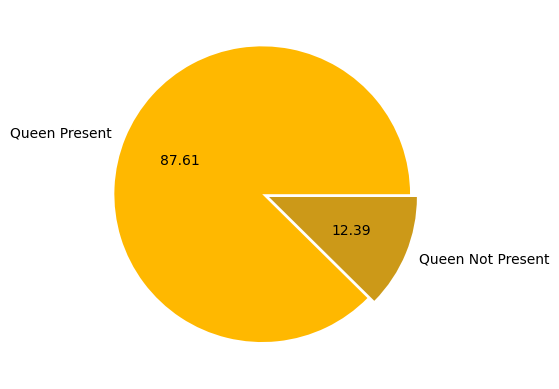

In [ ]:
plt.pie(dataset["queen presence"].value_counts(), labels=["Queen Present", "Queen Not Present"], colors=["#FFB800","#CC9918"], explode=(0,0.05), autopct="%0.2f")
plt.show()

Notiamo un **forte sbilanciamento** all'interno del nostro dataset causato dalla considerevole disparità tra le istanze appartenenti alla classe di nostro interesse, che denota l'assenza dell'ape regina, rispetto alle istanze dell'altra classe, che denota invece la presenza dell'ape regina.

Procediamo ora con il controllo della presenza di eventuali valori nulli:

In [ ]:
null_mask = dataset.isna()
null_count = null_mask.sum()
null_count

device                0
hive number           0
date                  0
hive temp             0
hive humidity         0
hive pressure         0
weather temp          4
weather humidity      0
weather pressure      0
wind speed            4
gust speed          994
weatherID             0
cloud coverage        0
rain                  0
lat                   4
long                  4
file name             0
queen presence        0
queen acceptance      0
frames                0
target                0
time                  0
queen status          0
dtype: int64

Osserviamo che le uniche colonne che presentano valori nulli sono poco rilevanti per affrontare il nostro problema, quindi questa è una problematica che ci riguarda ben poco.

# Data Preparation

Una volta individuati i problemi che coinvolgono il nostro dataset, procediamo ad applicare le soluzioni discusse.

Come abbiamo precedentemente spiegato, le uniche colonne che ci interessano all'interno del nostro dataset sono _"file name"_ e _"queen presence"_ per ricavare il file audio con la corrispettiva label. Di conseguenza, procediamo con l'**eliminazione delle colonne che non ci servono**:

In [ ]:
# Abilitiamo la visualizzazione delle tabelle di Colab
data_table.enable_dataframe_formatter()

dataset = dataset.drop(["device", "hive number", "hive pressure", "weather pressure", "wind speed", "gust speed", "weatherID",
             "cloud coverage", "rain", "lat", "long", "queen acceptance", "frames", "target", "queen status",
              "date", "time", "hive temp", "weather temp", "hive humidity", "weather humidity"], axis=1)

dataset

,file name,queen presence
0,2022-06-08--14-52-28_1.raw,1
1,2022-06-08--15-51-41_1.raw,1
2,2022-06-08--17-21-53_1.raw,0
3,2022-06-08--18-20-59_1.raw,0
4,2022-06-08--19-20-04_1.raw,0
...,...,...
1270,2022-07-15--11-18-39_2.raw,1
1271,2022-07-15--12-25-14_2.raw,1
1272,2022-07-15--13-25-58_2.raw,1
1273,2022-07-15--14-24-58_2.raw,1


Poiché il ronzio delle api è un suono tendenzialmente ritmico e difficilmente soggetto a forti variazioni, si è deciso di lavorare con solo **tre segmenti** per traccia audio, in modo da alleggerire il processo di creazione degli spettrogrammi senza perdere una quantità eccessiva di informazioni potenzialmente significative. Inoltre, al fine di uniformare la durata delle tracce audio, tutte quelle di cui non si dispongono almeno tre segmenti sono state rimosse dal dataset. Infine, i segmenti appartenenti alla stessa registrazione sono stati **uniti in un'unica traccia** da 3 minuti.

<u>*Nota: poiché non è ideale caricare una grande mole di file (la cartella che contiene le tracce audio pesa circa 22 GB), all'interno di Colab il seguente codice **non può essere eseguito**, ma denota solo gli step effettuati. Per maggiori informazioni visualizzare la documentazione.*</u>

In [ ]:
# DO NOT RUN
audio_dir =  # Rappresenta la directory in cui sono situati i segmenti dei file audio
merged_audio_dir =  # Rappresenta la directory in cui verranno caricati i file audio uniti

# Creazione della lista dei nomi dei file
audio_list = os.listdir(audio_dir)

# Definizione di tre insiemi per trovare file audio con meno di tre segmenti
segment0_set = set()
segment1_set = set()
segment2_set = set()

# Aggiunta dei segmenti audio nei relativi insiemi
for file in audio_list:
    if file.endswith("segment0.wav"):  # Aggiunta dei segmenti 0 all'insieme "segment0_set"
        file = file[:-14]
        segment0_set.add(file)
    if file.endswith("segment1.wav"):  # Aggiunta dei segmenti 1 all'insieme "segment1_set"
        file = file[:-14]
        segment1_set.add(file)
    if file.endswith("segment2.wav"):  # Aggiunta dei segmenti 2 all'insieme "segment2_set"
        file = file[:-14]
        segment2_set.add(file)

# Definizione di due insiemi contenenti i file audio da eliminare
set_to_remove1 = segment0_set.difference(segment1_set)  # Insieme contenente i file audio che presentano
# il segmento 0 ma non il segmento 1
set_to_remove2 = segment0_set.difference(segment2_set)  # Insieme contenente i file audio che presentano
# il segmento 0 e il segmento 1 ma non il segmento 2

# Eliminazione dei file audio che presentano solo i segmenti 0 e 1. In altre parole, si eliminano i file audio
# che non presentano almeno tre segmenti
for file in audio_list:
    file = file[:-14]
    if file in set_to_remove1:
        if os.path.exists(audio_dir + "/" + file + "__segment0.wav"):
            file = file + "__segment0.wav"
            os.remove(audio_dir + "/" + file)
    if file in set_to_remove2:
        if os.path.exists(audio_dir + "/" + file + "__segment0.wav"):
            file = file + "__segment0.wav"
            os.remove(audio_dir + "/" + file)
        if os.path.exists(audio_dir + "/" + file + "__segment1.wav"):
            file = file + "__segment1.wav"
            os.remove(audio_dir + "/" + file)

# Eliminazione di tutti i segmenti 3, 4 e 5
for file in audio_list:
    file = file[:-14]
    if os.path.exists(audio_dir + "/" + file + "__segment3.wav"):
        file = file + "__segment3.wav"
        os.remove(audio_dir + "/" + file)
    if os.path.exists(audio_dir + "/" + file + "__segment4.wav"):
        file = file + "__segment4.wav"
        os.remove(audio_dir + "/" + file)
    if os.path.exists(audio_dir + "/" + file + "__segment5.wav"):
        file = file + "__segment5.wav"
        os.remove(audio_dir + "/" + file)

# Unione dei segmenti 0, 1 e 2 in un unico file audio da tre minuti
for i in (range(int(len(audio_list)/3))):
    segment0 = AudioSegment.from_wav(audio_dir + "/" + audio_list[i * 3])
    segment1 = AudioSegment.from_wav(audio_dir + "/" + audio_list[i * 3 + 1])
    segment2 = AudioSegment.from_wav(audio_dir + "/" + audio_list[i * 3 + 2])
    merged_file_name = audio_list[i * 3][:-14] + ".wav"
    merged = segment0 + segment1 + segment2
    merged.export(merged_audio_dir + "/" + merged_file_name, format="wav")

Eseguite le operazioni sopra indicate, da 7100 tracce audio siamo passati a 1195.

Adesso, occorre ottenere gli **spettrogrammi** dei corrispettivi file audio, che saranno dati in input alla rete neurale. Poiché la seguente operazione è molto onerosa, si è deciso di parallelizzarla in 5 thread (5 è l'ultimo divisore utile di 1195 per creare un buon split). Inoltre, è bene notare che il seguente algoritmo causa un memory leak dovuto alla libreria *MatPlotLib* (diagnosticato attraverso *pympler*). Il nostro intervento al riguardo consiste nella forzatura del ***garbage collector*** alla fine di ogni iterazione per mitigare tale problematica. Inoltre si è rivelato necessario implementare un controllo all'inizio dell'algoritmo, così da poterlo fermare e rilanciare al riempimento della memoria senza generare nuovamente gli spettrogrammi già ottenuti. Per questo stesso motivo, sconsigliamo fortemente di eseguire il seguente script, gli spettrogrammi già computati sono forniti da noi all'interno di <u>src/ai/resources/spectograms</u> nella repository GitHub.

<u>*Nota: si è deciso di computare gli spettrogrammi in questo punto e non in seguito ad ulteriori operazioni di data cleaning così da fornire tutti gli spettrogrammi possibili del nostro dataset (anche se non verranno utilizzati tutti), proprio perché l'esecuzione di questo algoritmo risulta essere particolarmente onerosa. Così facendo possiamo permettere, se lo si desidera, di effettuare ulteriori test senza passare per questo step.*</u>

In [ ]:
# DO NOT RUN
spectrograms_dir =  # Rappresenta la directory in cui verranno caricati gli spettrogrammi
THREAD_NO = 5  # Definizione del numero di thread per la parallelizzazione

merged_audio_list = os.listdir(merged_audio_dir)
spectrogram_list = os.listdir(spectrograms_dir)


# Creazione degli spettrogrammi relativi a ogni file audio
def spectrograms(i):
    # Ogni thread itera su un proprio range di file audio
    thread_range = range(i * (len(merged_audio_list)/THREAD_NO),
                         (i+1) * (len(merged_audio_list)/THREAD_NO))

    for item in thread_range:
        audio_file = merged_audio_list[item]
        if (audio_file[:-4] + "_spect.png") in spectrogram_list:
            continue  # Non aggiungiamo l'immagine se essa è già presente nella cartella
        else:
            # Caricamento del file audio
            y, sr = librosa.load(merged_audio_dir + "\\" + audio_file, sr=None)
            # Realizzazione dello spettrogramma
            spect = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
            # Visualizzazione dello spettrogramma
            librosa.display.specshow(spect, sr=sr, x_axis='time', y_axis='log')
            # Eliminazione degli assi dall'immagine prodotta
            plt.axis("off")
            # Eliminazione del padding bianco attorno lo spettrogramma
            plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
            # Salvataggio dello spettrogramma nella cartella
            plt.savefig(spectrograms_dir + "\\" + audio_file[:-4] + "_spect.png")
            # Le variabili non sono più necessarie e vanno rimosse dalla memoria
            del y, sr, spect
            # Richiamo manuale del Garbage Collector per liberare la memoria occupata
            gc.collect()


# Chiamata alla funzione spectrograms su cinque thread diversi
if __name__ == '__main__':  # Si assicura l'esecuzione del blocco solo sul processo principale
    with multiprocessing.Pool(THREAD_NO) as p:
        p.map(spectrograms, [0, 1, 2, 3, 4])

Ora, è necessario **eliminare le righe del dataset** i cui file audio sono stati precedentemente eliminati da noi (i file che non presentavano almeno tre segmenti) e di cui non esiste la traccia audio corrispondente in primo luogo (riportati nel dataset, ma non presenti nella nostra cartella come .wav). Per farlo, cambiamo innanzitutto il nome dei file nel dataset in modo che corrisponda al formato degli spettrogrammi prodotti precedentemente, poiché d'ora in poi ci concentreremo su questi.

<u>_Nota: per eseguire il codice con le annotazioni "DO NOT RUN WITHOUT DIR" da questo punto in poi, è necessario caricare all'interno di Colab la cartella con gli spettrogrammi (è possibile trovarla su GitHub sotto la cartella menzionata precedentemente e, nel caso in cui venisse modificato il nome, aggiornare il seguente blocco di codice prima di eseguirlo)._</u>

In [ ]:
# Prima di eseguire assicurarsi che la cartella sia presente su Colab e che il nome della cartella sia corretto
spectrograms_dir = "spectrograms"  # Rappresenta la directory in cui verranno caricati gli spettrogrammi

In [ ]:
# DO NOT RUN WITHOUT DIR
dataset["file name"] = dataset["file name"].str[:-4] + "_spect.png"
spectrograms_list = os.listdir(spectrograms_dir)
ds_filename_list = dataset["file name"].tolist()
files_to_remove = set(ds_filename_list) - set(spectrograms_list)
dataset = dataset[~dataset["file name"].isin(files_to_remove)]

Eseguite le operazioni sopra indicate, da 1275 campioni nel dataset siamo passati a 1195, che corrisponde al numero di spettrogrammi in nostro possesso.

Continuiamo con l'**estrazione di un piccolo dataset pseudocasuale** che verrà utilizzato nella **valutazione** del nostro modello. Eseguiamo ora tale operazione perché vogliamo che l'algoritmo non veda mai questi dati, così da poterlo testare in maniera corretta. Il numero di righe per ogni label è arbitrario e non è dettato da una particolare euristica, se non dall'arrotondamento delle righe in cui la regina è assente.

In [2]:
# Disabilitiamo la visualizzazione delle tabelle di Colab per questioni di performance
data_table.disable_dataframe_formatter()

demo_dataset_half_1 = dataset.loc[dataset["queen presence"] == 1].sample(92)  # Righe in cui la regina è presente
demo_dataset_half_2 = dataset.loc[dataset["queen presence"] == 0].sample(8)  # Righe in cui la regina è assente

demo_ds = pd.concat([demo_dataset_half_1, demo_dataset_half_2], axis=0)  # Unione delle due metà del dataset
demo_ds.to_csv("CNN_demo_dataset.csv", index=False)  # Esportazione in CSV
dataset = dataset.drop(demo_ds.index)  # Eliminazione delle righe estratte dal dataset originale

demo_ds

Ora dobbiamo prendere atto dello sbilanciamento delle nostre classi. Sono due i possibili approcci da considerare:

*     Effettuare un semplice **undersampling della classe maggioritaria**, ottenendo complessivamente 300 campioni, diviso in 150 in cui l'ape regina è presente e 150 in cui l'ape regina non è presente. Ovviamente questo comporterebbe un'enorme perdita di dati, ma i ronzii delle api sono generalmente molto simili tra loro per cui non comportano particolari differenze nei loro spettrogrammi. Per tale motivo, anche disponendo di pochi campioni, possiamo aspettarci prestazioni decenti dalla nostra rete;

*          Produrre più campioni **tagliando gli spettrogrammi a metà e trattandoli come due sample di dati**, in modo da raddoppiare il numero totale. Questo approccio sembra buono sulla carta, ma potrebbe portare a un maggiore overfitting poiché, come detto precedentemente, i ronzii sono molto simili tra loro. Inoltre, nasce una nuova problematica nel momento in cui l'anomalia si trova solo in una porzione dello spettrogramma, portandoci a dei dati errati.

Poiché la seconda opzione è un notevole investimento di tempo per un riscontro minimo, abbiamo optato la prima:

In [ ]:
# Undersampling della classe maggioritaria (regina presente) a 150 campioni
cnn_dataset = dataset.groupby("queen presence").apply(lambda x: x.sample(n=min(150, len(x))))
cnn_dataset = cnn_dataset.reset_index(drop=True)
cnn_dataset.to_csv("CNN_dataset.csv", index=False)
cnn_dataset

,device,hive number,date,hive temp,hive humidity,hive pressure,weather temp,weather humidity,weather pressure,wind speed,...,rain,lat,long,file name,queen presence,queen acceptance,frames,target,time,queen status
0,1,4,2022-06-26 16:43:48,33.43,49.17,1009.35,29.25,45,1014,6.69,...,0,37.29,-121.95,2022-06-26--16-43-48_1_spect.png,0,0,8,1,0.667,1
1,2,1,2022-06-26 8:49:43,37.48,36.42,1011.06,20.01,62,1017,0.00,...,0,37.29,-121.95,2022-06-26--08-49-43_2_spect.png,0,0,10,0,0.333,1
2,1,4,2022-06-26 5:51:52,29.24,67.52,1009.89,14.36,86,1015,1.54,...,0,37.29,-121.95,2022-06-26--05-51-52_1_spect.png,0,0,8,1,0.208,1
3,2,3,2022-06-09 4:12:46,15.90,59.00,1006.56,12.45,87,1012,0.45,...,0,37.29,-121.95,2022-06-09--04-12-46_2_spect.png,0,0,10,0,0.167,1
4,2,3,2022-06-09 0:15:57,18.52,47.68,1007.37,14.58,82,1013,5.14,...,0,37.29,-121.95,2022-06-09--00-15-57_2_spect.png,0,0,10,0,0.000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,2,1,2022-07-04 8:58:57,38.43,33.57,1009.75,18.23,72,1015,1.34,...,0,37.29,-121.95,2022-07-04--08-58-57_2_spect.png,1,2,10,5,0.333,3
296,2,3,2022-06-07 21:00:02,22.01,33.27,1008.88,16.99,50,1015,4.12,...,0,37.29,-121.95,2022-06-07--21-00-02_2_spect.png,1,2,10,5,0.875,0
297,2,3,2022-06-12 9:31:04,39.37,28.99,1005.51,22.56,70,1011,2.06,...,0,37.29,-121.95,2022-06-12--09-31-04_2_spect.png,1,1,10,4,0.375,2
298,2,1,2022-06-28 12:13:12,43.92,16.70,1011.84,27.23,42,1017,5.14,...,0,37.29,-121.95,2022-06-28--12-13-12_2_spect.png,1,1,10,4,0.500,2


Adesso dobbiamo trasformare i nostri dati in un formato accettabile dalla rete neurale, ovvero **array NumPy**. In particolare, durante la conversione delle immagini, è necessario eliminare una dimensione, che rappresenta il valore alfa (la trasparenza dell'immagine), il quale è costantemente impostato su 255 poiché i pixel sono sempre completamente opachi, trattandosi quindi di un'informazione superflua.

In [ ]:
# DO NOT RUN WITHOUT DIR
cnn_dataset = pd.read_csv("CNN_dataset.csv")
spectrogram_list = cnn_dataset["file name"].tolist()

# Creazione delle variabili per l'addestramento della CNN
X_train = []  # array contenente le immagini di ogni spettrogramma
y_train = np.asarray(cnn_dataset["queen presence"].tolist())  # array contenente le label

# Trasformazione delle immagini degli spettrogrammi in array NumPy da dare in input alla CNN
for file in spectrogram_list:
    image = Image.open(spectrograms_dir + "/" + file)
    image_array = np.asarray(image)[:, :, :-1]  # Rimozione di una dimensione dell'immagine (alpha)
    X_train.append(image_array)
X_train = np.asarray(X_train)

Eseguite queste ultime operazioni, i dati sono pronti per il training e si può passare alla prossima fase.

# Data Modeling


Durante la fase di training utilizziamo una **stratified k-fold** validation con k = 5. Questa scelta è motivata dal fatto che, per k = 10, il tempo di esecuzione risulta essere sensibilmente lento. Inoltre, considerando l'ampia sperimentazione empirica degli iperparametri (che implica numerosi cicli di fit del modello), non possiamo permetterci un tempo di computazione così alto.

Per migliorare la leggibilità, il processo di sperimentazione e ottimizzazione del modello è stato omesso da questo file. Qui riportiamo solo il testing del risultato che abbiamo identificato come il migliore basandoci sulle metriche ***Accuracy***, ***Precision*** e ***AUC*** e sfruttando la ***Binary Crossentropy*** come metrica di perdita. In particolare, abbiamo scelto la **Precision come metrica principale**, poiché in questo contesto specifico <u>il sistema è particolarmente sensibile ai falsi positivi</u>. Quest'ultimi sono i casi in cui l'ape regina è assente ma il modello prevede che è invece presente nell'arnia, conducendoci inevitabilmente a potenziali previsioni sbagliate di CCD. Per visualizzare l'intero processo di ottimizzazione e logging dei risultati, fare riferimento alla documentazione, dove si entra più nel dettaglio per quanto riguarda l'approccio utilizzato.

<u>_Nota: non è necessario eseguire i seguenti script. Il modello addestrato e pronto è fornito da noi ed è possibile trovarlo a questo [link](https://drive.google.com/drive/u/0/folders/1-9QYqQ02ekceGdyQ61xjTOjKwhGBPvom), all'interno della cartella "CNN Model"._</u>

Innanzitutto, inizializziamo le liste che conterranno i risultati ottenuti dall'addestramento. Queste liste ci torneranno utili successivamente, quando sarà necessario esaminare le prestazioni del modello:

In [ ]:
# Liste contenenti i valori di valutazione sul test set
val_loss_per_fold = []
val_accuracy_per_fold = []
val_precision_per_fold = []
val_AUC_per_fold = []

# Liste contenenti i valori di valutazione sul training set (per la diagnosi di overfitting)
training_loss_per_fold = []
training_accuracy_per_fold = []
training_precision_per_fold = []
training_AUC_per_fold = []

Successivamente, definiamo gli iperparametri. A tal proposito, vi sono delle considerazioni da fare su ognuno:


*   **Pooling:** l'Average Pooling risultava in prestazioni tendenzialmente peggiori rispetto al Max Pooling;
*   **Numero di neuroni per layer:** un numero minore di neuroni rispetto a quello scelto porta il modello all'overfitting, mentre un numero maggiore ha un costo computazionale troppo elevato;
*   **Optimizer:** altri optimizers oltre Adam presentano prestazioni pessime o causano l'esplosione del gradiente e conseguentemente della loss function;
*   **Numero di epoche:** il numero ottimale di epoche si assesta tra 3 e 4, poiché un numero inferiore porta all'underfitting, mentre un numero maggiore porta molto velocemente all'overfitting;
*   **Dimensione del batch:** una dimensione minore del batch non restituiva prestazioni degne di nota, mentre una dimensione maggiore rende l'algoritmo lento e da un costo computazionale elevato.



In [ ]:
pooling = "MaxPooling"
dense_neurons = 256
optimizer = "adam"
epochs = 4
batch_size = 16

Adesso, possiamo finalmente cominciare a **creare la nostra rete neurale**.

Dalla nostra sperimentazione empirica siamo giunti alla conclusione di dover utilizzare tre layer convoluzionali, di cui il primo con un kernel maggiore (le immagini sono grandi), poiché ci portano ai risultati migliori.

In [ ]:
# Applicazione della stratified k-fold validation (k = 5)
skf = StratifiedKFold(n_splits=5)
fold_no = 1
for train, test in skf.split(X_train, y_train):
    # Creazione della rete neurale
    model = Sequential()
    model.add(Conv2D(32, (5, 5), activation="relu", input_shape=(480, 640, 3)))  # Primo layer convoluzionale
    model.add(MaxPooling2D(pool_size=(2, 2)))  # Layer di Pooling
    model.add(Conv2D(64, (3, 3), activation="relu"))  # Secondo layer convoluzionale
    model.add(MaxPooling2D(pool_size=(2, 2)))  # Layer di Pooling
    model.add(Conv2D(128, (3, 3), activation="relu"))  # Terzo layer convoluzionale
    model.add(MaxPooling2D(pool_size=(2, 2)))  # Layer di Pooling
    model.add(Flatten())
    model.add(Dense(dense_neurons, activation="relu"))  # Layer Completamente Connesso (Fully Connected)
    model.add(Dense(1, activation="sigmoid"))  # Layer di output

    # Compilazione della CNN
    metrics = ["accuracy", keras.metrics.Precision(name="precision"), keras.metrics.AUC(name="auc")]
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=metrics)

    # Addestramento del modello + Visualizzazione dei risultati a video per ogni fold
    print(f"--------- Fold n. {fold_no} ---------")
    history = model.fit(X_train[train], y_train[train], epochs=epochs, batch_size=batch_size,
                        validation_data=(X_train[test], y_train[test]))

    # Valutazione del modello per comprendere l'affidabilità della configurazione
    eval = model.evaluate(X_train[test], y_train[test], verbose=0)

    # Salvataggio delle metriche di testing attraverso l'oggetto eval
    val_loss_per_fold.append(eval[0])
    val_accuracy_per_fold.append(eval[1] * 100)
    val_precision_per_fold.append(eval[2] * 100)
    val_AUC_per_fold.append(eval[3])

    # Salvataggio delle metriche di training attraverso l'oggetto history
    training_loss_per_fold.append(history.history["loss"][epochs-1])
    training_accuracy_per_fold.append(history.history["accuracy"][epochs-1] * 100)
    training_precision_per_fold.append(history.history["precision"][epochs-1] * 100)
    training_AUC_per_fold.append(history.history["auc"][epochs-1])

    # Passaggio all'iterazione successiva, quindi al prossimo fold
    fold_no += 1

Adesso, riportiamo qui di seguito i risultati dell'addestramento, facendo uso delle liste inizializzate precedentemente. Così facendo, possiamo decidere quale modello utilizzare nello specifico.

In [ ]:
# Salvataggio dei risultati all'interno di un log per la configurazione di iperparametri utilizzata
print("VALUTAZIONE TRAINING:\n"
f"Training Loss: {np.mean(training_loss_per_fold):.4f}, Training Accuracy: {np.mean(training_accuracy_per_fold):.4f}%, "
f"Training Precision: {np.mean(training_precision_per_fold):.4f}%, Training AUC: {np.mean(training_AUC_per_fold):.4f}"
"\n\nVALUTAZIONE TESTING:\n"
f"Test Loss: {np.mean(val_loss_per_fold):.4f}, Test Accuracy: {np.mean(val_accuracy_per_fold):.4f}%, "
f"Test Precision: {np.mean(val_precision_per_fold):.4f}%, Test AUC: {np.mean(val_AUC_per_fold):.4f}\n")

Procediamo, infine, al training con l'intero dataset a nostra disposizione per poi salvare il modello ottenuto.

In [ ]:
# Creazione della rete neurale
model = Sequential()
model.add(Conv2D(32, (5, 5), activation="relu", input_shape=(480, 640, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

# Compilazione della CNN
metrics = ["accuracy", keras.metrics.Precision(name="precision"), keras.metrics.AUC(name="auc")]
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=metrics)

# Addestramento del modello e visualizzazione dei risultati a video per ogni fold
model.fit(X_train, y_train, epochs=4, batch_size=16)

# Salvataggio del modello
# Il codice è commentato poichè vogliamo evitare di sovraccaricare Colab. Rircordiamo che il modello è presente nel link sopra citato
# model.save("CNN.keras")

Ora che abbiamo ottenuto la nostra rete neurale, possiamo valutarla utilizzando il demo set precedentemente estratto.

# Evaluation

Prima di tutto, carichiamo la nostra rete neurale (ricordiamo che è possibile trovarla a questo [link](https://drive.google.com/drive/u/0/folders/1-9QYqQ02ekceGdyQ61xjTOjKwhGBPvom)) all'interno della cartella <u>CNN Model</u>

<u>*Nota: Talvolta Colab non carica correttamente il modello a causa della sua grandezza. I risultati dell'evaluation sono comunque riportati sotto forma di testo o immagine, quindi non è strettamente necessario scaricare il modello. Nel caso lo si desideri, si consiglia di runnare lo script situato all'interno della repository GitHub sotto src/ai/development/CNN/5_evaluation.py dopo aver inserito nella stessa cartella il modello caricato nel Drive*</u>

In [ ]:
# Caricamento del modello
model = keras.models.load_model("CNN.keras")

Successivamente, recuperiamo il **dataset contenente le righe estratte** precedentemente dal dataset originale per effettuare la validazione:

In [ ]:
cnn_demo_dataset = pd.read_csv("CNN_demo_dataset.csv")
cnn_demo_dataset

,device,hive number,date,hive temp,hive humidity,hive pressure,weather temp,weather humidity,weather pressure,wind speed,...,rain,lat,long,file name,queen presence,queen acceptance,frames,target,time,queen status
0,1,5,2022-06-08 15:51:41,33.56,33.98,1006.93,25.99,53,1012,10.29,...,0,37.29,-121.95,2022-06-08--15-51-41_1_spect.png,1,2,8,0,0.625,0
1,1,4,2022-07-09 0:40:46,27.42,80.63,1014.12,15.81,80,1019,2.06,...,0,37.29,-121.95,2022-07-09--00-40-46_1_spect.png,1,2,8,3,0.000,3
2,2,3,2022-06-07 19:01:46,24.31,34.76,1008.42,21.16,44,1014,8.23,...,0,37.29,-121.95,2022-06-07--19-01-46_2_spect.png,1,2,10,5,0.792,0
3,2,3,2022-06-13 10:49:36,49.96,13.64,1010.54,20.75,50,1016,5.66,...,0,37.29,-121.95,2022-06-13--10-49-36_2_spect.png,1,1,10,4,0.417,2
4,2,3,2022-06-12 16:25:11,31.28,36.12,1004.90,22.56,67,1011,9.77,...,0,37.29,-121.95,2022-06-12--16-25-11_2_spect.png,1,1,10,4,0.667,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,5,2022-06-09 0:15:56,22.51,49.07,1007.58,14.58,82,1013,5.14,...,0,37.29,-121.95,2022-06-09--00-15-56_1_spect.png,0,0,8,1,0.000,1
96,1,4,2022-06-26 10:48:55,35.52,53.75,1011.14,25.71,41,1017,2.06,...,0,37.29,-121.95,2022-06-26--10-48-55_1_spect.png,0,0,8,1,0.417,1
97,1,5,2022-06-09 2:14:24,22.11,48.18,1006.91,13.54,84,1013,2.06,...,0,37.29,-121.95,2022-06-09--02-14-24_1_spect.png,0,0,8,1,0.083,1
98,1,4,2022-06-25 19:00:41,32.77,54.16,1007.11,25.82,43,1012,6.17,...,0,37.29,-121.95,2022-06-25--19-00-41_1_spect.png,0,0,8,1,0.792,1


Come effettuato durante la Data Preparation, andiamo a recuperare gli spettrogrammi e li trasformiamo in un formato accettabile dalla rete neurale, ovvero **array NumPy**. Procediamo allo stesso e identico modo.

In [ ]:
# DO NOT RUN WITHOUT DIR
demo_spectrogram_list = cnn_demo_dataset["file name"].tolist()

X_test = []  # array contenente le immagini di ogni spettrogramma
y_test = np.asarray(cnn_demo_dataset["queen presence"].tolist())  # array contenente le label

# Trasformazione delle immagini degli spettrogrammi in array NumPy da dare in input alla CNN
for file in spectrogram_list:
    image = Image.open(spectrograms_dir + "/" + file)
    image_array = np.asarray(image)[:, :, :-1]  # Rimozione di una dimensione dell'immagine (alpha)
    X_test.append(image_array)
X_test = np.asarray(X_test)

Procediamo ad **effettuare le previsioni**.

In [ ]:
prediction = model.predict(X_test)
prediction = prediction.flatten()
prediction = np.where(prediction > 0.5, 1, 0)

Ora, **valutiamo le performance** risultanti:

In [ ]:
eval = model.evaluate(X_test, y_test, verbose=0)
# Le metriche sono riportate in forma testuale poiché Colab talvolta non carica correttamente il modello
print(f"Loss: {eval[0]:.4f}, Accuracy: {(eval[1] * 100):.4f}, Precision: {(eval[2] * 100):.4f}, AUC: {eval[3]:.4f}")

**Loss**: 0.7917, **Accuracy**: 53.0000, **Precision**: 95.9184, **AUC**: 0.7867



Una volta effettuata la valutazione, creiamo la **_confusion matrix_** relativa alla nostra CNN.

In [ ]:
# Creazione matrice di confusione
matrix = confusion_matrix(y_true = y_test, y_pred = prediction)

# Definizione dei colori da utilizzare nella matrice con relativa color map e color matrix
colors=['#FFB800', '#805711']
color_map = ListedColormap('white', name='colormap_list')
color_matrix = [['#FFB800', '#805711'], ['#805711', '#FFB800']]
color_text_matrix = [['black', 'white'], ['white', 'black']]

# Visualizzazione matrice di confusione
plt.imshow(matrix, cmap=color_map, origin='upper')

for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        # Definizione dei dettagli in merito a colore e testo per le celle della matrice
        plt.text(j, i, str(matrix[i, j]), color=color_text_matrix[i][j])
        plt.fill_between([j-0.5, j+0.5], i-0.5, i+0.5, color=color_matrix[i][j], alpha=1)

# Set dei valori e delle labels presenti su asse x e asse y
plt.xticks([0, 1])
plt.yticks([0, 1])
plt.xlabel('Predicted label')
plt.ylabel('True label')

# La confusion matrix è riportata in forma di immagine poiché Colab talvolta non carica correttamente il modello
plt.show()

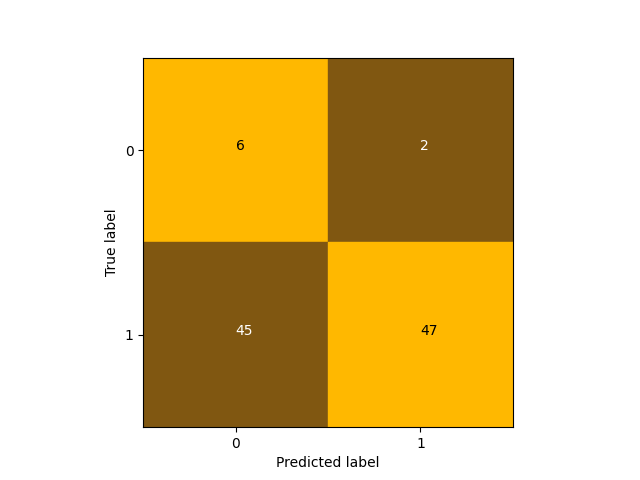

Infine, generiamo la **_ROC Curve_**:

In [ ]:
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, prediction)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.4f})'.format(auc(false_positive_rate, true_positive_rate), color="#FFB800")
plt.title('ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='best')
# La ROC Curve è riportata in forma di immagine poiché Colab talvolta non carica correttamente il modello
plt.show()

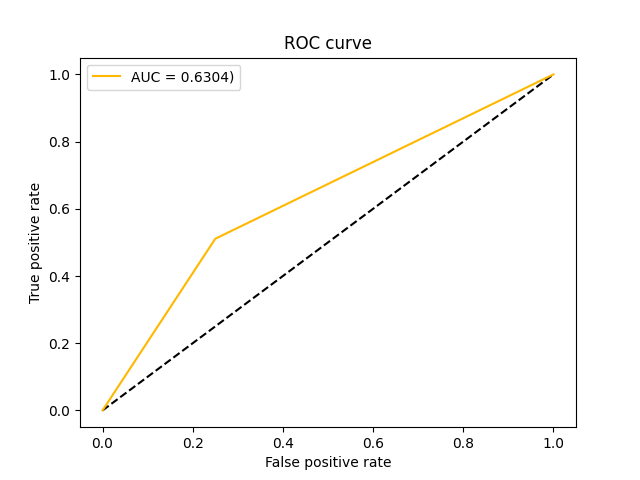

Vi sono delle ultime considerazioni da fare. Ci rendiamo conto che le prestazioni della rete neurale da noi sviluppata non sono delle migliori, soprattutto per quanto riguarda l'accuratezza. Per poterla ottimizzare ulteriormente, sarebbe senza dubbio necessario un quantitativo maggiore di dati. Tuttavia, il quantitativo di dati riguardo questa particolare problematica è limitato, e volendo evitare l'applicazione della tecnica di oversampling discussa precedentemente, non abbiamo avuto alternative. Inoltre uno studio più attento e meticoloso della teoria delle reti neurali potrebbe far emergere concetti a noi attualmente non del tutto chiari, che potrebbero dar vita a nuove intuizioni per migliorare il lavoro svolto. Fino ad oggi, però, possiamo ritenerci indubbiamente soddisfatti del risultato ottenuto e del processo svolto per raggiungerlo.

# Deployment

Finalmente, la nostra CNN è pronta e possiamo metterla in funzione a supporto del nostro modello di Machine Learning, così da renderlo completo. Per il Deploy si è optato per utilizzare Flask, rendendo la nostra CNN un servizio web con cui è possibile comunicare attraverso HTTP, così da renderla un modulo importabile anche esternamente, per integrarla eventualmente con altri sistemi software. Per questioni di semplicità si è inoltre deciso di lavorare con i nomi dei file degli spettrogrammi, ma in un ambiente reale ciò che andrebbe passato è il file audio registrato da dei sensori, da convertire a spettrogramma col rispettivo codice per poi farlo passare alla CNN (questo ovviamente non cambia in alcun modo la logica di predizione, è una semplice astrazione a fini di semplicità).

In [ ]:
# Inizializziamo Flask
app = Flask(__name__)

# Ascoltiamo sull'url http://127.0.0.1:5000/predict_cnn_fia per permetterci di comunicare attraverso HTTP
@app.route("/predict_cnn_fia",methods=["POST"])
def predict_CNN():
    if request.method == "POST":
        # Lavoriamo con i nomi degli spettrogrammi per questione di semplicità, idealmente qui
        # avremmo passato il file audio generato dai sensori per convertirlo in uno spettrogramma
        decoded_data = request.data.decode("utf-8")
        input = json.loads(decoded_data)
        file_name = input["file"]

        # Apriamo l'immagine e la convertiamo in un formato leggibile alla CNN
        image = Image.open("..\\..\\resources\\spectrograms\\" + file_name)
        image_array = np.asarray(image)[:, :, :-1]
        to_predict = []
        to_predict.append(image_array)
        to_predict = np.asarray(to_predict)

        # Effettuiamo la previsione
        prediction = model.predict(to_predict, batch_size = 1)
        prediction = prediction.flatten()
        prediction = np.where(prediction > 0.5, 1, 0)

        # Restituiamo la previsione
        return jsonify ({"cnn_result": int(prediction[0])})

if __name__ == "__main__":
    app.run()